## 이 파일의 목적

svm을 제외한 모델에서의 결과를 살펴보고 본다. 여기선 oversampling(smooth)와 minmax가 사용되었다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install lightgbm
!pip install ngboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 6.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=a59f71bca35344dc1a2feec5d5d280e37323c2c6bb62c9e0e3443644081bae54
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 8.5 MB/s eta 0:00:00


In [ ]:
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
# matplotlib 의 기본 scheme 말고
# seaborn scheme 을 세팅하여, 일일이 graph의 font size 지정할 필요 없이
# seaborn 의 font_scale 을 사용하는 것을 추천드립니다.
plt.style.use('seaborn')
sns.set(font_scale=2.5)
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from ngboost import NGBClassifier, NGBRegressor
from lightgbm.plotting import plot_importance
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax


# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

import shap

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

<Figure size 1600x800 with 0 Axes>

In [ ]:
# 이제 마지막 데이터셋! 더이상 바뀔 일 없음
path = '/content/drive/MyDrive/Colab Notebooks/model/4.27_lendingclub_individual_dataset.csv'
df = pd.read_csv(path)
df

,emp_length_int,installment,int_rate,loan_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,mort_acc,num_rev_accts,open_acc,open_acc_6m,open_act_il,revol_bal,revol_util,loan_status,total_pymnt,funded_amnt_inv,earliest_cr_line_year,earliest_cr_line_month,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,verification_status_Source Verified,verification_status_Verified
0,2,822.95,14.47,35000.0,30.0,154.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,6.0,1.0,1.0,24640.0,0.354,Current,16430.860000,35000.0,2002,12,2018,9,5,717.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,10,680.82,24.99,23200.0,126.0,277.0,0.0,0.0,0.0,0.0,1.0,2.0,22.0,24.0,1.0,10.0,16909.0,0.559,Charged Off,8599.680000,23200.0,1993,5,2016,7,3,672.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,10,145.06,9.93,4500.0,127.0,265.0,0.0,0.0,0.0,1.0,1.0,0.0,27.0,22.0,2.0,0.0,6435.0,0.121,Current,4204.260000,4500.0,1995,11,2017,12,6,677.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,494.55,7.07,16000.0,134.0,400.0,0.0,0.0,0.0,0.0,0.0,3.0,18.0,18.0,1.0,2.0,3881.0,0.055,Charged Off,11804.280000,16000.0,1984,5,2017,10,7,822.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,5,146.10,10.42,4500.0,226.0,130.0,2.0,2.0,0.0,0.0,0.0,1.0,6.0,7.0,1.0,2.0,6824.0,0.494,Fully Paid,5134.174383,4500.0,1998,7,2017,5,6,702.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535624,7,133.78,19.99,3600.0,151.0,36.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,8.0,1.0,1.0,9711.0,0.908,Charged Off,469.070000,3600.0,2001,8,2014,3,3,667.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1535625,4,583.89,6.68,19000.0,125.0,216.0,0.0,0.0,0.0,0.0,0.0,5.0,16.0,15.0,1.0,4.0,11421.0,0.414,Fully Paid,20620.112719,18875.0,1997,3,2015,4,7,737.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1535626,9,329.65,14.33,9600.0,25.0,99.0,0.0,0.0,0

In [ ]:
not_deliq = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

loan_stat = df['loan_status']
target = []
for stat in loan_stat:
    # 연체 하지 않은 경우를 0
    if stat in not_deliq:
        target.append(0)
    # 연체한 경우를 1
    else:
        target.append(1)
print(len(target))
print(len(df))

1535629
1535629


In [ ]:
df['target'] = target

In [ ]:
# # 계산을 위한 항은 미리 빼서 dataframe에 저장해둠.
# df_cal = pd.DataFrame()
# df_cal = df[['installment','funded_amnt_inv', 'int_rate', 'total_pymnt', 'installment', 'term_ 60 months', 'target']]
# # 이중 total이랑 funded는 실제론 사용하면 안됨.

In [ ]:
# current와 issued를 제거
df = df[df['loan_status']!= 'Current']
df = df[df['loan_status']!= 'Issued']

In [ ]:
df.drop(columns = 'loan_status', inplace = True)

In [ ]:
# X와 y를 나누기 위해 list 생성
x_data = list(df.columns)
x_data.remove('target')
# 이 밑에는 사후변수!
x_data.remove('total_pymnt')
x_data.remove('funded_amnt_inv')

In [ ]:
x_data

['emp_length_int',
 'installment',
 'int_rate',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'pub_rec',
 'pub_rec_bankruptcies',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'inq_last_6mths',
 'mort_acc',
 'num_rev_accts',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'revol_bal',
 'revol_util',
 'earliest_cr_line_year',
 'earliest_cr_line_month',
 'issue_d_year',
 'issue_d_month',
 'grade_numeric',
 'fico_range_mean',
 'home_ownership_MORTGAGE',
 'home_ownership_NONE',
 'home_ownership_OTHER',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_educational',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'term_ 60 months',
 'addr_state_AL',
 'addr_state_AR',
 'addr_state_AZ',
 'addr_state_CA',
 'addr_state_CO',
 '

In [ ]:
column_types = df.dtypes

# float와 int 나누기
float_columns = []
int_columns = []
for column_name, dtype in column_types.items():
    if dtype == 'float':
        float_columns.append(column_name)
    elif dtype == 'int':
        int_columns.append(column_name)


# 데이터 유형에 따라 변환
df[float_columns] = df[float_columns].astype(np.float32)
df[int_columns] = df[int_columns].astype(np.int8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1070411 entries, 1 to 1535627
Data columns (total 98 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   emp_length_int                       1070411 non-null  int8   
 1   installment                          1070411 non-null  float32
 2   int_rate                             1070411 non-null  float32
 3   loan_amnt                            1070411 non-null  float32
 4   mo_sin_old_il_acct                   1070411 non-null  float32
 5   mo_sin_old_rev_tl_op                 1070411 non-null  float32
 6   pub_rec                              1070411 non-null  float32
 7   pub_rec_bankruptcies                 1070411 non-null  float32
 8   chargeoff_within_12_mths             1070411 non-null  float32
 9   collections_12_mths_ex_med           1070411 non-null  float32
 10  inq_last_6mths                       1070411 non-null  float32
 11  mor

## MinMAx scaler 적용

In [ ]:
processing = ['emp_length_int',
 'installment',
 'int_rate',
 'loan_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'pub_rec',
 'pub_rec_bankruptcies',
 'chargeoff_within_12_mths',
 'collections_12_mths_ex_med',
 'inq_last_6mths',
 'mort_acc',
 'num_rev_accts',
 'open_acc',
 'open_acc_6m',
 'open_act_il',
 'revol_bal',
 'revol_util']

# 이거만 바꿀지 다 바꿀지, 의견 물어보고 나의 의견도 제시하면 될듯.
# 우선은 dummy는 안바꾸는게 낫다는 의견 존재

In [ ]:
# standard로 scale
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[processing])

# 새로운 DF에 스케일된 데이터를 저장
df[processing] = scaled_data

In [ ]:
# 우선 랜덤하게 data_split하고 돌려봄 0.8:0.2
df_train, df_test = train_test_split(df, test_size = .2, train_size = 0.8, random_state = 42)
df_train, df_validation = train_test_split(df_train, test_size = .25, train_size = 0.75, random_state = 42)

In [ ]:
X_train = df_train[x_data]
y_train = df_train['target']

X_test = df_validation[x_data]
y_test = df_validation['target']
# Target

In [ ]:
# train셋을 oversampling
from imblearn.over_sampling import BorderlineSMOTE
smt = BorderlineSMOTE()
X_train, y_train = smt.fit_resample(df_train[x_data], df_train['target'])

In [ ]:
df_train.describe()

,emp_length_int,installment,int_rate,loan_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,pub_rec,pub_rec_bankruptcies,chargeoff_within_12_mths,collections_12_mths_ex_med,inq_last_6mths,mort_acc,num_rev_accts,open_acc,open_acc_6m,open_act_il,revol_bal,revol_util,total_pymnt,funded_amnt_inv,earliest_cr_line_year,earliest_cr_line_month,issue_d_year,issue_d_month,grade_numeric,fico_range_mean,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 60 months,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,verification_status_Source Verified,verification_status_Verified,target
count,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.00000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000,642246.000000
mean,0.002379,0.001561,0.001297,0.001605,0.001521,0.000613,0.000453,0.000167,0.000933,-0.000351,-0.000641,-0.000416,0.000559,0.000196,-0.001568,0.000975,-0.000042,0.001413,15003.385742,14368.353516,-48.790801,6.742814,-32.497949,6.501001,5.311479,699.214844,0.486835,0.000028,0.000089,0.111171,0.401203,0.223715,0.570588,0.000215,0.065494,0.006136,0.022384,0.011852,0.007141,0.061300,0.000715,0.011108,0.007231,0.001238,0.247086,0.012301,0.007296,0.024196,0.143605,0.021705,0.015145,0.002499,0.002786,0.071991,0.032467,0.004888,0.000008,0.001601,0.039058,0.016140,0.008193,0.009493,0.011312,0.023043,0.023664,0.001864,0.026412,0.017601,0.015762,0.005219,0.002806,0.028047,0.001404,0.002997,0.004905,0.036444,0.005440,0.015047,0.082459,0.032654,0.009017,0.012041,0.033662,0.004464,0.012097,0.001945,0.015211,0.081435,0.007317,0.028351,0.00206,0.020928,0.012998,0.003502,0.002152,0.398179,0.285780,0.195343
std,1.000172,1.000638,1.000505,1.000303,0.998175,1.000133,1.004758,1.000591,1.005437,0.999166,1.000359,1.001262,0.999427,0.999277,0.997933,1.001068,0.988150,0.999063,10579.628906,88

In [ ]:
def show_time(diff):
   m, s = divmod(diff, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(mean_squared_error(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model


# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 20,15
    plt.bar(model_scores['Model'], height=model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs=[i for i in range(0,17)]
    xlabs=[i for i in range(0,17)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

In [ ]:
prediction_times = []
training_times = []
scores = []

decision_tree = Train(DecisionTreeClassifier(max_depth=5), X_train, y_train, X_test, y_test) # 결정트리
random_forest= Train(RandomForestClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test) # 랜덤 포레스트. Essemble 중 bagging에 대표적인 모델
extra_trees = Train(ExtraTreesClassifier(n_estimators=50,max_depth=5), X_train, y_train, X_test, y_test) # 랜덤 포레스트와 유사하지만, bagging은 아니다. 속도도 빠르고 bias도 varinace도 줄일 수 있다고 하지만... 최고라고 하기엔 흠?
xgboost = Train(XGBClassifier(n_estimators=100, max_depth=5), X_train, y_train, X_test, y_test)
lgb = Train(LGBMClassifier(n_estimators=100, max_depth=5, num_leaves = 70), X_train, y_train, X_test, y_test)
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=5), X_train, y_train, X_test, y_test)
# xgboost = Train(XGBClassifier(max_depth= 10, min_child_weight= 6, learning_rate = 0.1, n_estimators= 100, penalty= 'ridge', objective = 'binary:logistic', eval_metric = 'auc'), X_train, y_train, X_test, y_test)
# lgb = Train(LGBMClassifier(n_estimators=150, max_depth=20, num_leaves=150,learning_rate = 0.1, objective = 'binary', verbose=1), X_train, y_train, X_test, y_test)
# cat = Train(CatBoostClassifier(l2_leaf_reg= 5, n_estimators=200, learning_rate = 0.1, verbose=1, depth=6, loss_function='Logloss'), X_train, y_train, X_test, y_test)
ngb = Train(NGBClassifier(n_estimators=50, verbose=1, natural_gradient=3), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:11

Prediction time: 
Execution Time: 00:00:00
Training time: 
Execution Time: 00:00:47

Prediction time: 
Execution Time: 00:00:01
Training time: 
Execution Time: 00:00:20

Prediction time: 
Execution Time: 00:00:01
Training time: 
Execution Time: 00:00:04

Prediction time: 
Execution Time: 00:00:00
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 516788, number of negative: 516788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4487
[LightGBM] [Info] Number of data points in the train set: 1033576, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

특이도(Specificity): 0.755723552141473
민감도(Sensitivity) 또는 재현율(Recall): 0.4321733294986099
정확도(Accuracy): 0.6926644930447212
정밀도(Precision): 0.29985865136775586


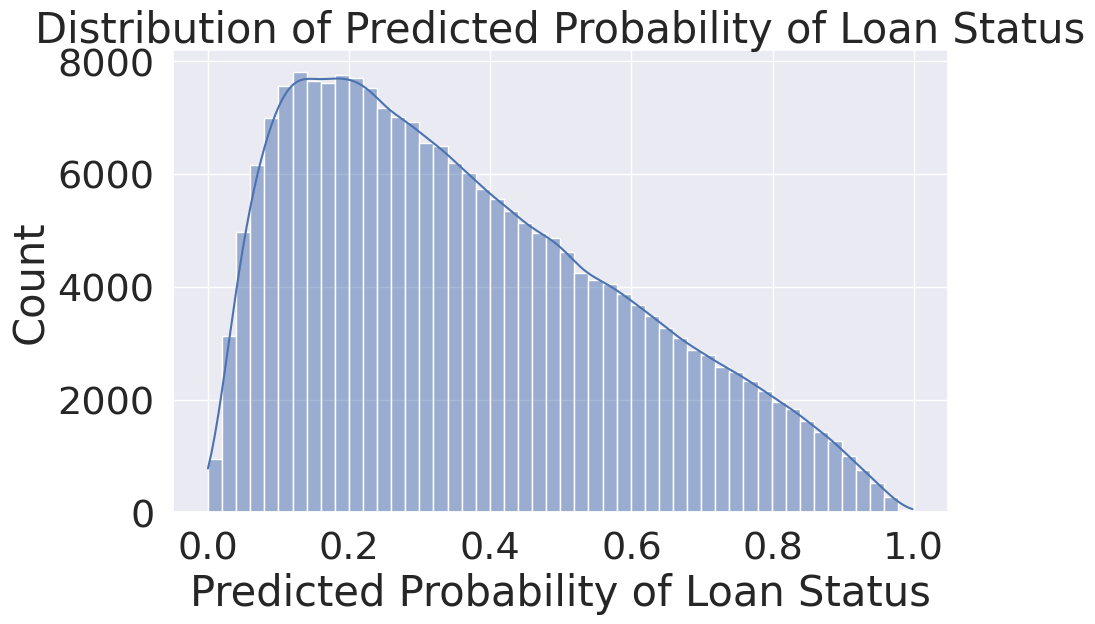

              precision    recall  f1-score   support

           0       0.85      0.76      0.80    172358
           1       0.30      0.43      0.35     41724

    accuracy                           0.69    214082
   macro avg       0.57      0.59      0.58    214082
weighted avg       0.74      0.69      0.71    214082



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score


# 독립 변수와 종속 변수 분리
# X = df.drop('target', axis=1)  # 독립 변수
# y = df['target']  # 종속 변수

# # 데이터 정규화
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # 훈련 데이터와 테스트 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # 오버샘플링 적용
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 다중 회귀 모델 훈련
model = LogisticRegression()
model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 특이도(Specificity), 민감도(재현율), 정확도, 정밀도 계산
conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()
specificity = TN / (TN + FP)
recall = sensitivity = TP / (TP + FN)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("특이도(Specificity):", specificity)
print("민감도(Sensitivity) 또는 재현율(Recall):", recall)
print("정확도(Accuracy):", accuracy)
print("정밀도(Precision):", precision)

# 예측 결과의 분포 시각화
y_pred_proba = model.predict_proba(X_test)[:, 1]
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.xlabel('Predicted Probability of Loan Status')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probability of Loan Status')
plt.show()

from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test)))

In [ ]:
models = [
    ('DecisionTree', decision_tree),
    ('RandomForest', random_forest),
    ('ExtraTrees', extra_trees),
    ('XGBoost', xgboost),
    ('LightGBM', lgb),
    ('CatBoost', cat),
    ('NgBoost', ngb),
    ('Logistic', model)
]

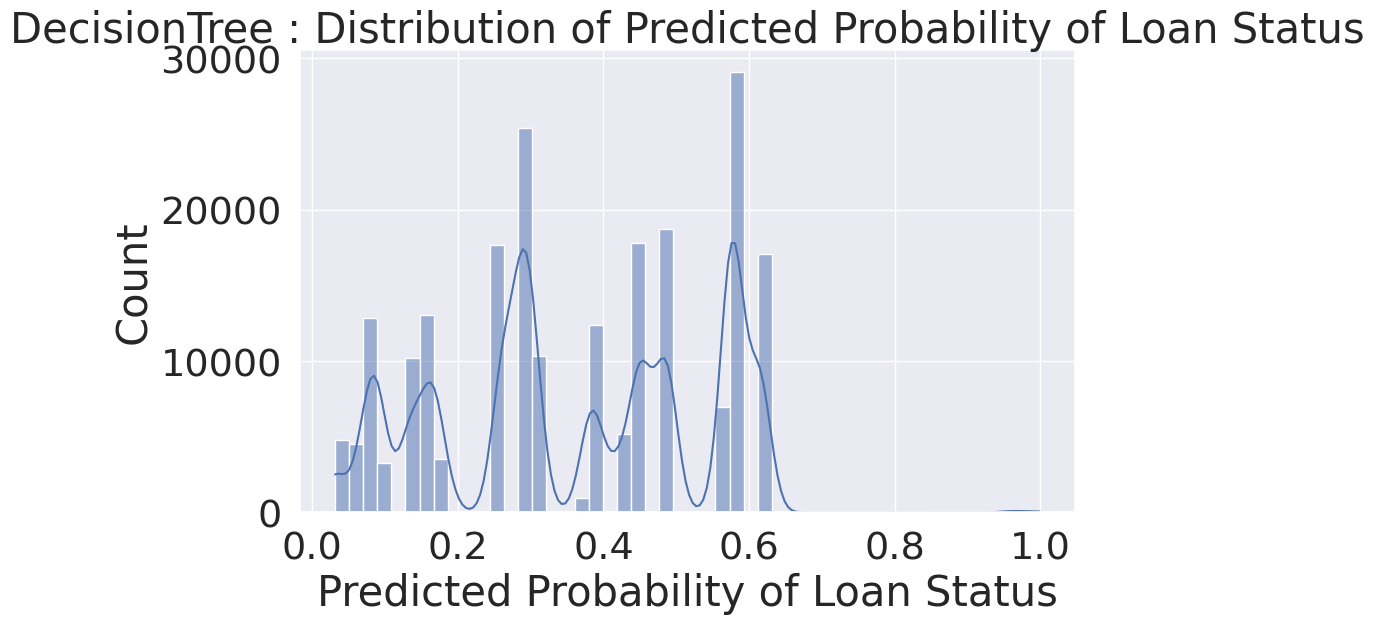

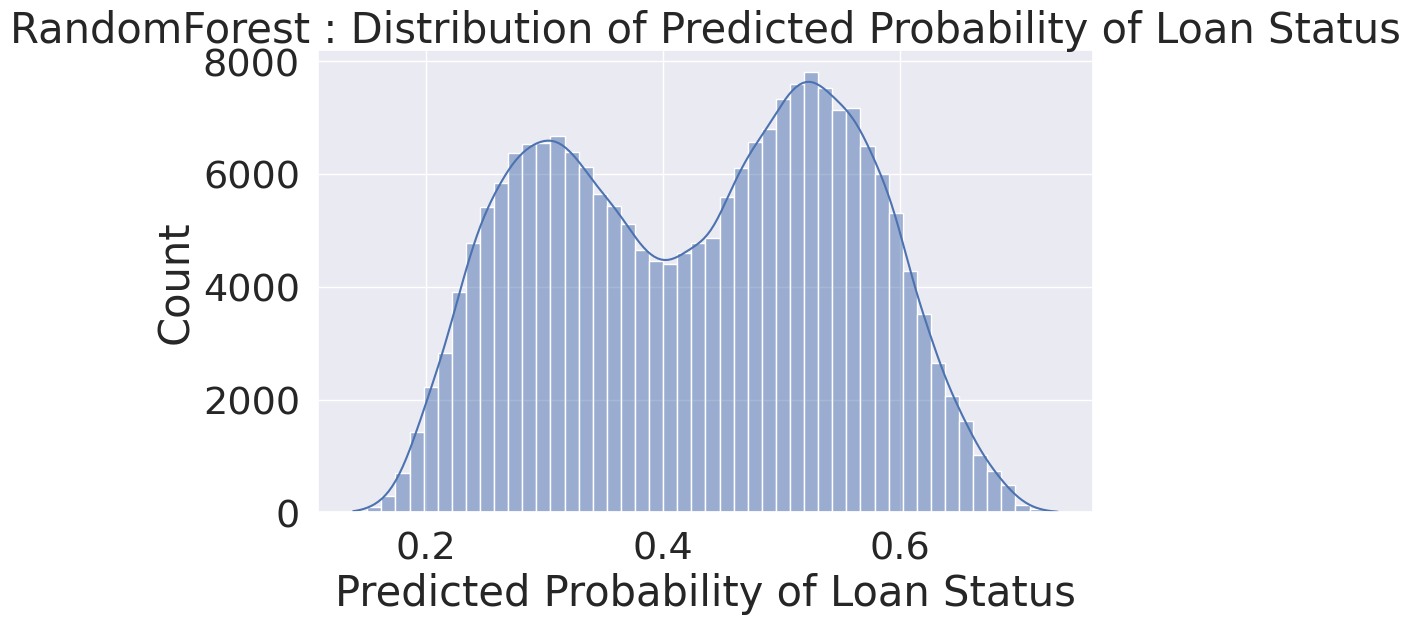

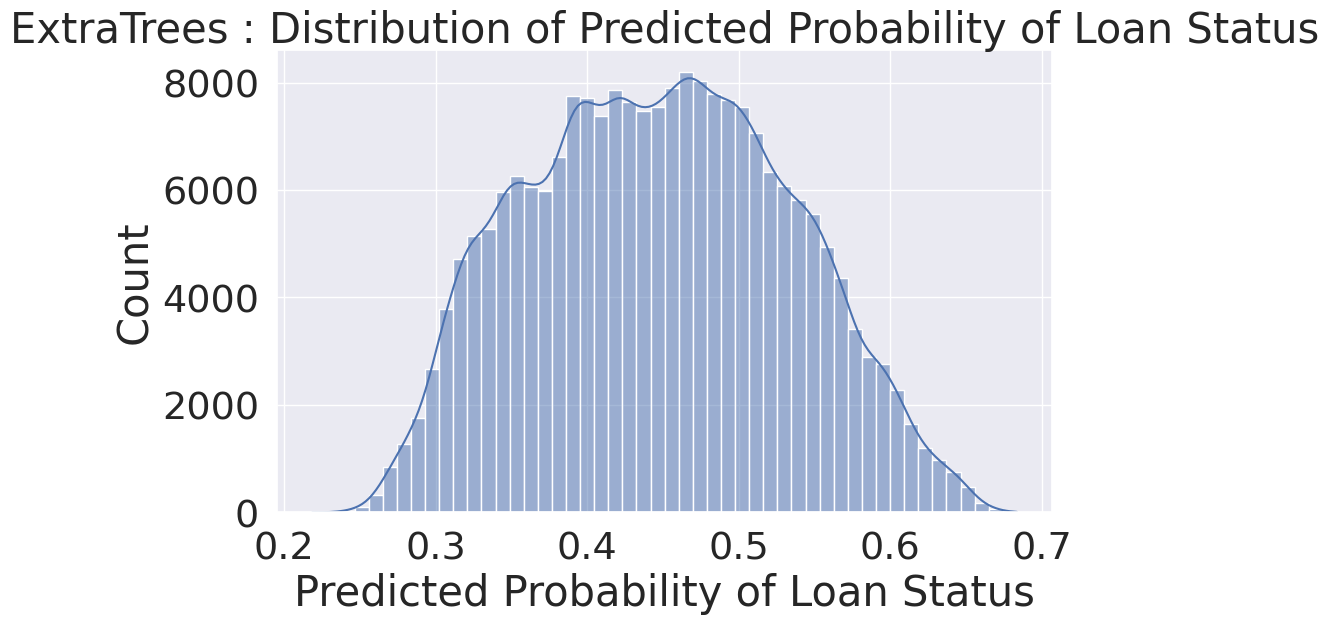

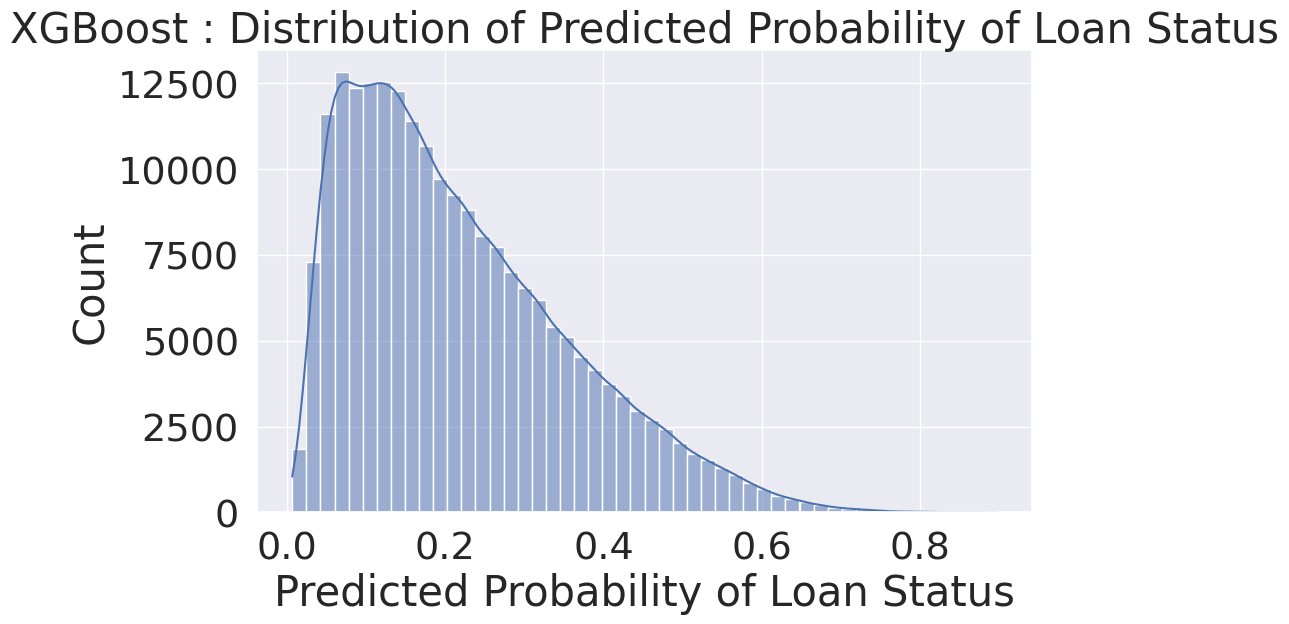

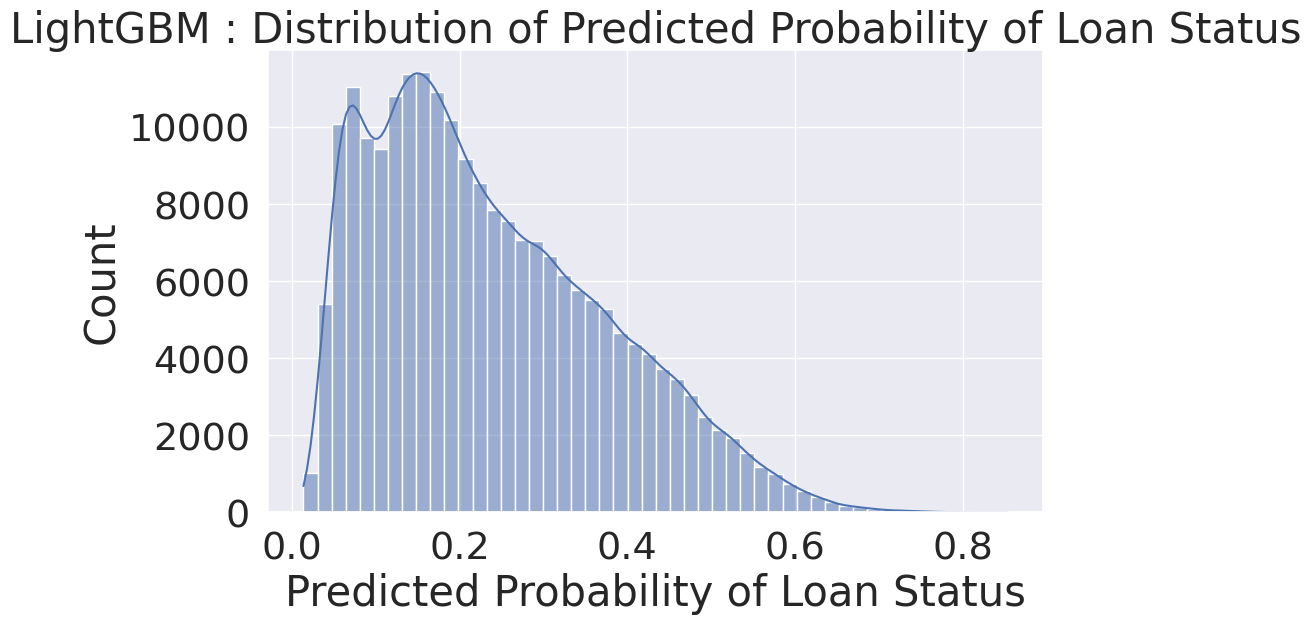

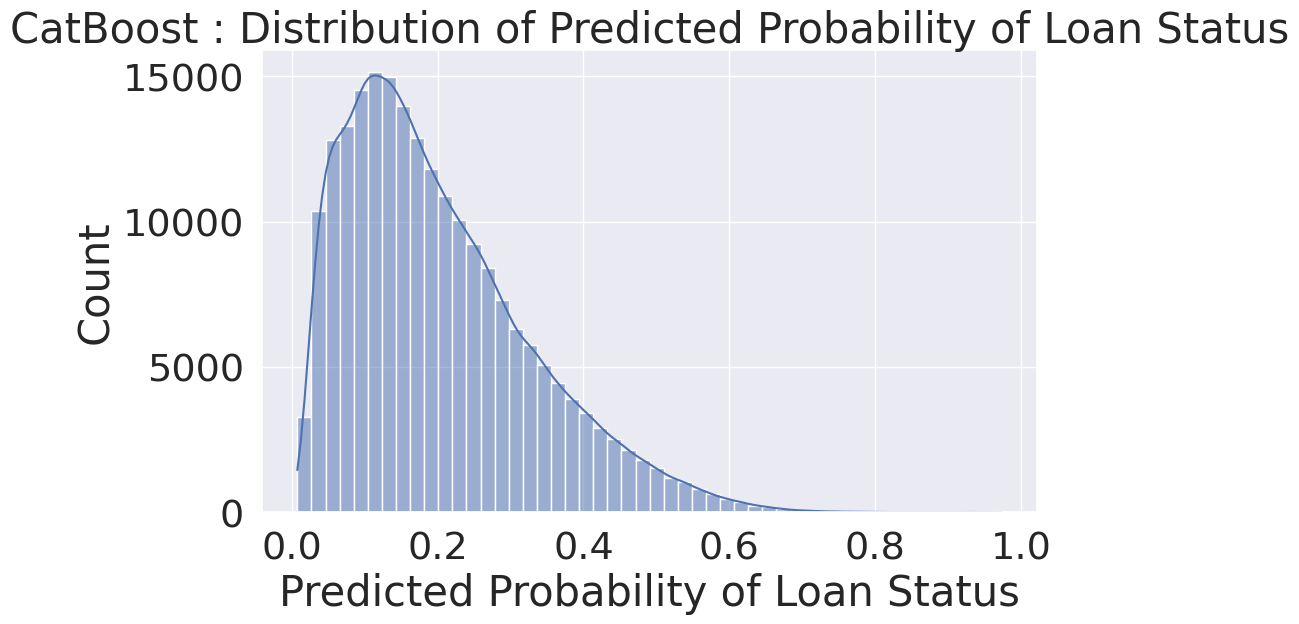

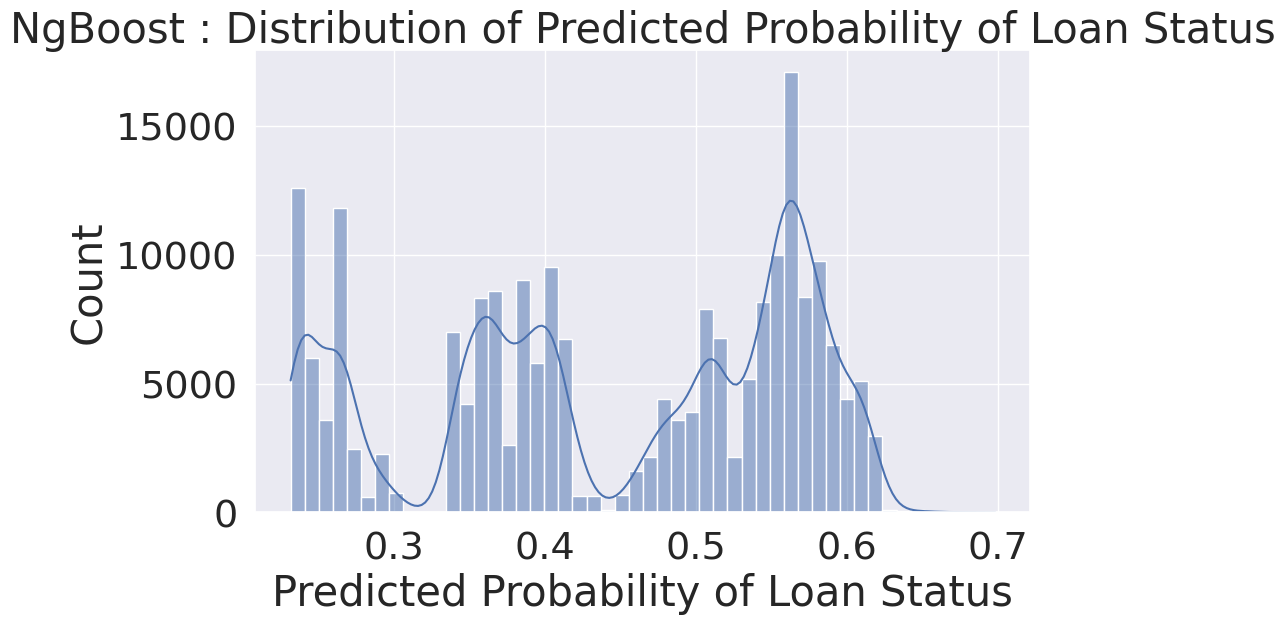

In [ ]:
# 예측 결과의 분포 시각화 (logsitc 제외)
for name, model in models[:-1]:
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred_proba, bins=50, kde=True)
    plt.xlabel('Predicted Probability of Loan Status')
    plt.ylabel('Count')
    plt.title(f'{name} : Distribution of Predicted Probability of Loan Status')
    plt.show()

In [ ]:
# score에 있는 점수를 소수점 5째자리까지 반올림
scores.append(accuracy)
for i in range(len(scores)):
    scores[i] = round(scores[i],5)
scores

[0.70429, 0.6675, 0.69195, 0.80369, 0.80114, 0.807, 0.61587, 0.69266]

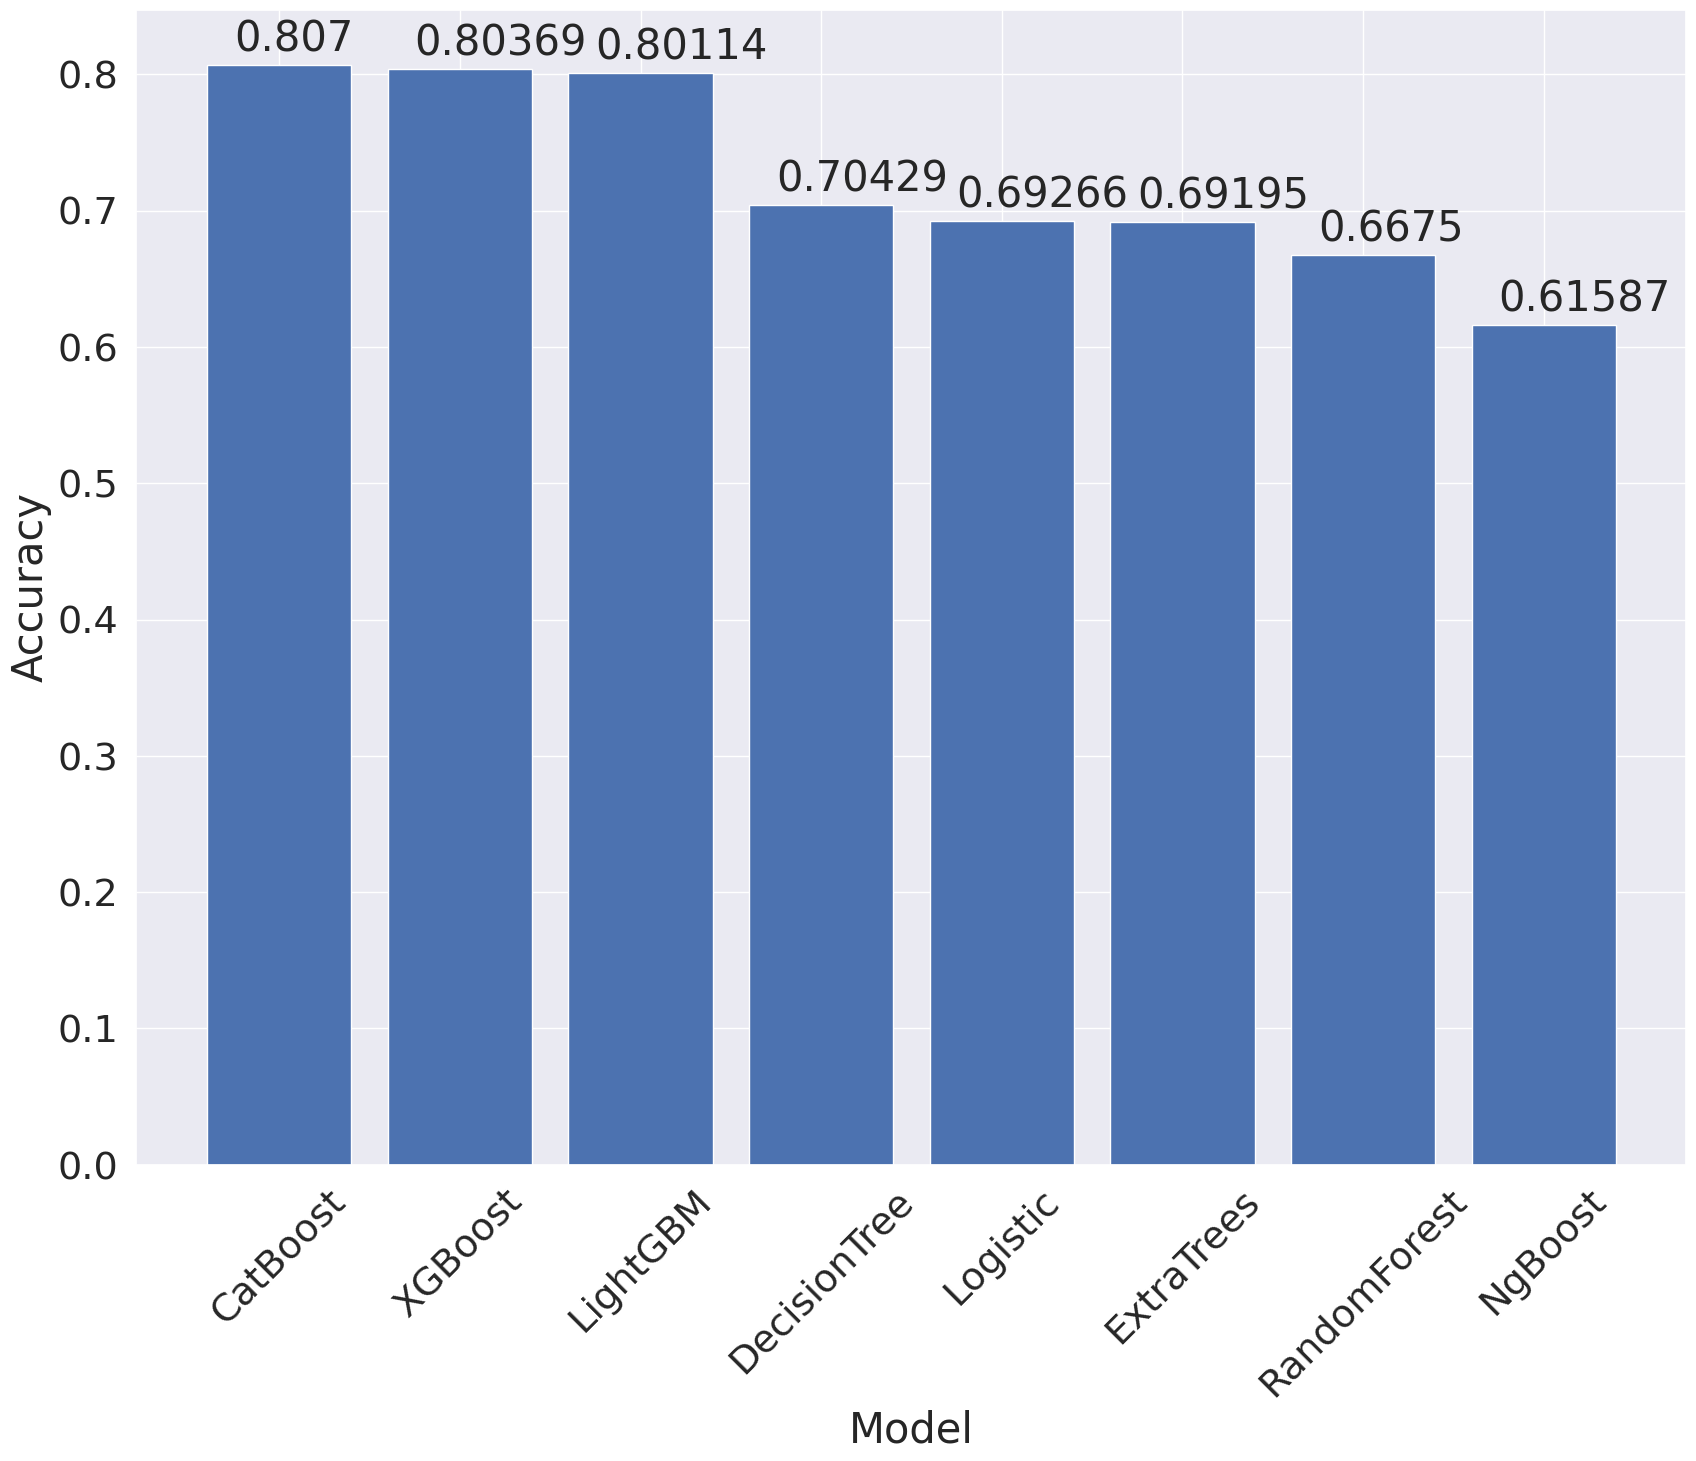

In [ ]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy',ascending=False,inplace=True)
plot_metric(model_scores, score='Accuracy')

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrices = {}
# 각 모델에 대한 전퓨전 매트릭스 상성
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(X_test)
    # 컨퓨전 매트릭스 생성
    cm = confusion_matrix(y_test, y_pred)
    # 딕셔너리에 저장
    confusion_matrices[name] = cm

# 컨퓨전 매트릭스 출력
for name, cm in confusion_matrices. items():
    print(f"Confusion Matrix for {name}")
    print (cm)
    print()

Confusion Matrix for DecisionTree
[[134841  37517]
 [ 25789  15935]]

Confusion Matrix for RandomForest
[[119536  52822]
 [ 18361  23363]]

Confusion Matrix for ExtraTrees
[[129103  43255]
 [ 22693  19031]]

Confusion Matrix for XGBoost
[[167412   4946]
 [ 37081   4643]]

Confusion Matrix for LightGBM
[[166704   5654]
 [ 36918   4806]]

Confusion Matrix for CatBoost
[[169528   2830]
 [ 38488   3236]]

Confusion Matrix for NgBoost
[[104105  68253]
 [ 13983  27741]]

Confusion Matrix for Logistic
[[130255  42103]
 [ 23692  18032]]



In [ ]:
from sklearn.metrics import classification_report
for name, model in models:
    print(name)
    print(classification_report(y_test, model.predict(X_test)))
    print('----------------------------------------------------------------------------')

DecisionTree
              precision    recall  f1-score   support

           0       0.84      0.78      0.81    172358
           1       0.30      0.38      0.33     41724

    accuracy                           0.70    214082
   macro avg       0.57      0.58      0.57    214082
weighted avg       0.73      0.70      0.72    214082

----------------------------------------------------------------------------
RandomForest
              precision    recall  f1-score   support

           0       0.87      0.69      0.77    172358
           1       0.31      0.56      0.40     41724

    accuracy                           0.67    214082
   macro avg       0.59      0.63      0.58    214082
weighted avg       0.76      0.67      0.70    214082

----------------------------------------------------------------------------
ExtraTrees
              precision    recall  f1-score   support

           0       0.85      0.75      0.80    172358
           1       0.31      0.46      0.37   

In [ ]:
from sklearn.metrics import classification_report
for name, model in models:
    print(name)
    print(classification_report(df_test['target'], model.predict(df_test[x_data])))
    print('----------------------------------------------------------------------------')

DecisionTree
              precision    recall  f1-score   support

           0       0.84      0.78      0.81    172469
           1       0.30      0.39      0.34     41614

    accuracy                           0.71    214083
   macro avg       0.57      0.58      0.57    214083
weighted avg       0.74      0.71      0.72    214083

----------------------------------------------------------------------------
RandomForest
              precision    recall  f1-score   support

           0       0.87      0.70      0.77    172469
           1       0.31      0.56      0.40     41614

    accuracy                           0.67    214083
   macro avg       0.59      0.63      0.59    214083
weighted avg       0.76      0.67      0.70    214083

----------------------------------------------------------------------------
ExtraTrees
              precision    recall  f1-score   support

           0       0.85      0.75      0.80    172469
           1       0.31      0.46      0.37   

                       feature  importance
27          home_ownership_OWN    0.133507
37               purpose_other    0.093023
10              inq_last_6mths    0.058403
14                 open_acc_6m    0.052221
34      purpose_major_purchase    0.048204
32    purpose_home_improvement    0.047653
30  purpose_debt_consolidation    0.039995
22               grade_numeric    0.038396
15                 open_act_il    0.028053
28         home_ownership_RENT    0.025361


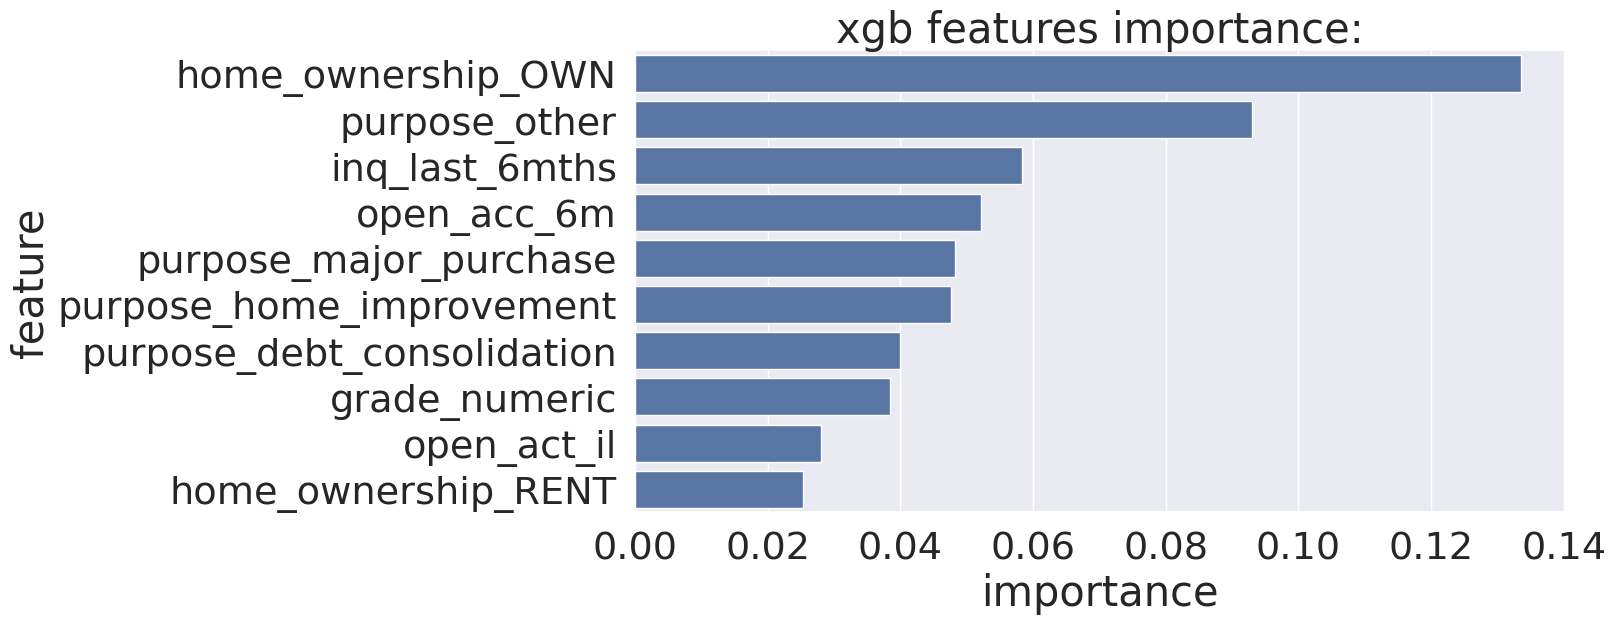

In [ ]:
feature_importances(X_train, xgboost, "xgb")

            feature  importance
22    grade_numeric         326
15      open_act_il         242
2          int_rate         219
20     issue_d_year         183
3         loan_amnt         168
0    emp_length_int         164
11         mort_acc         159
10   inq_last_6mths         143
14      open_acc_6m         138
42  term_ 60 months         129


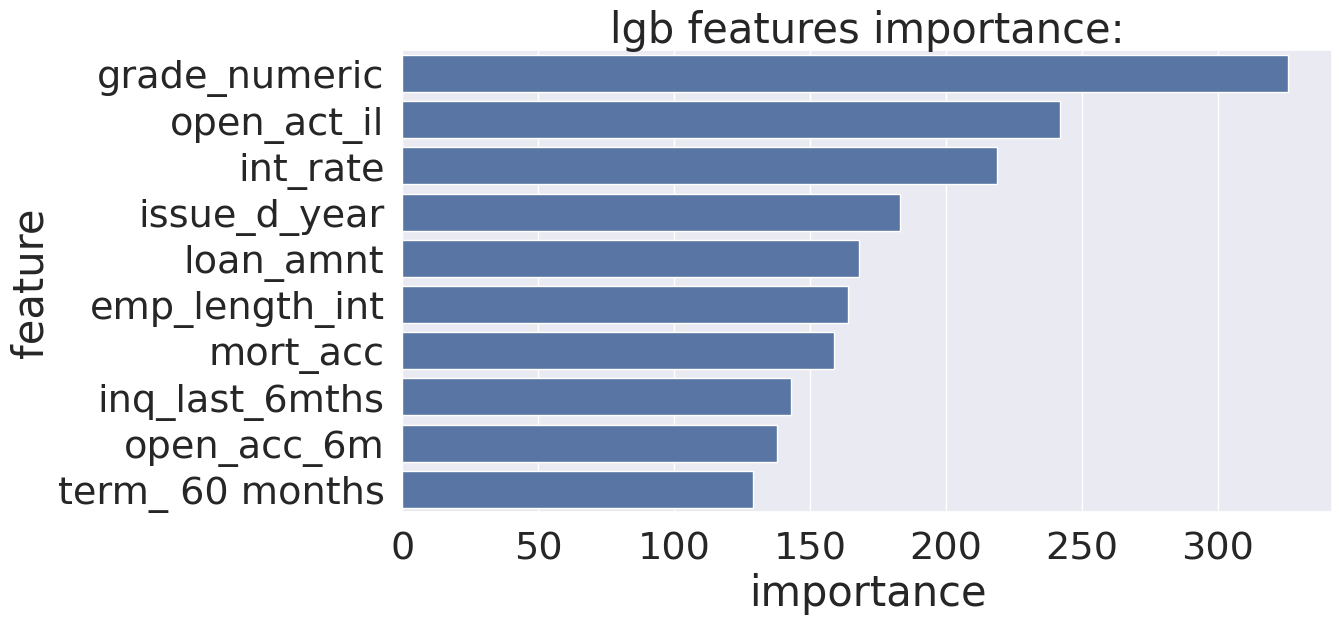

In [ ]:
feature_importances(X_train, lgb, 'lgb')

                    feature  importance
14              open_acc_6m   21.609682
13                 open_acc   15.845667
15              open_act_il   15.530512
11                 mort_acc   14.701468
10           inq_last_6mths   14.082580
0            emp_length_int    8.157165
24  home_ownership_MORTGAGE    3.287199
28      home_ownership_RENT    2.874950
27       home_ownership_OWN    1.611386
22            grade_numeric    0.858391


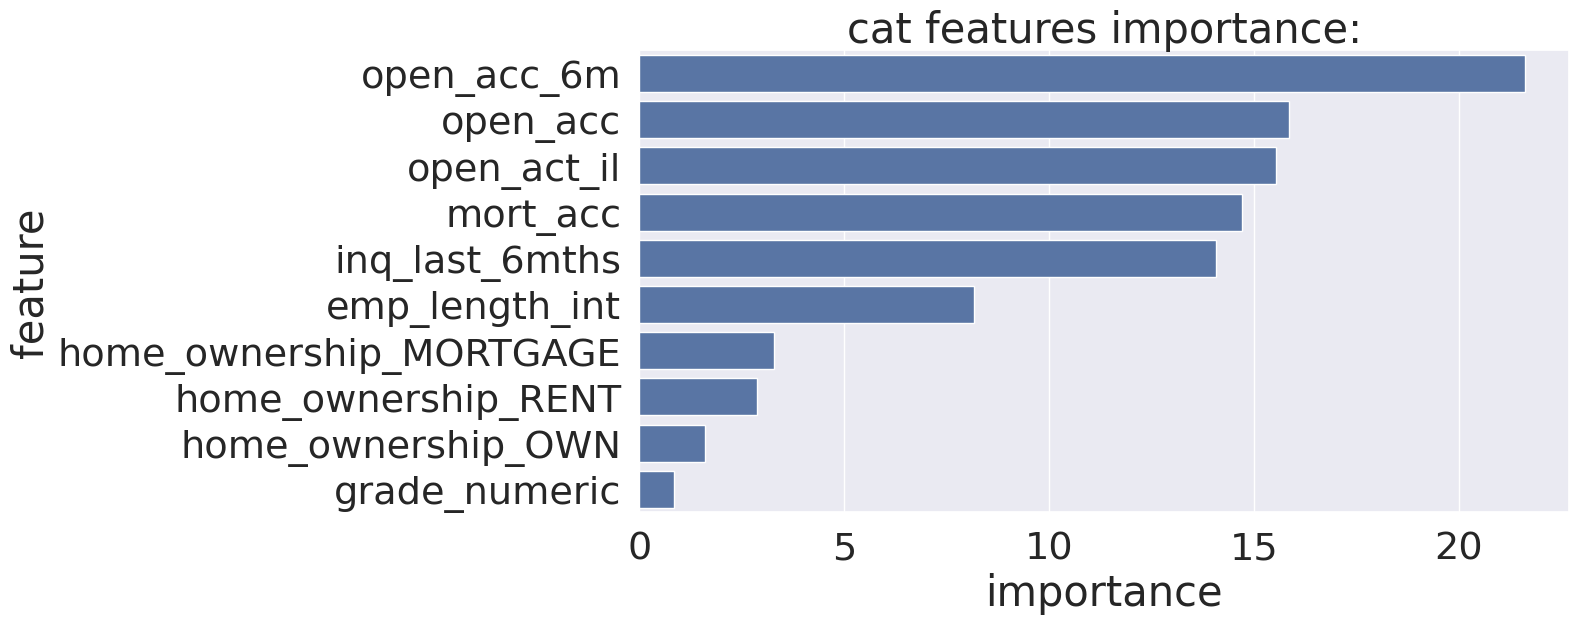

In [ ]:
feature_importances(X_train, cat, 'cat')

In [ ]:
for name, model in models:
    # 모델의 예측값 얻기
    y_pred = model.predict(X_test)
    # df_cal에 저장
    df_cal[name] = y_pred

NameError: name 'df_cal' is not defined

## 수익률 계산
1. 우수작 사례 - 개별로 계산
2. 현준님 계산 - 모두 평균으로 계산
3. 비교

여기서 threshold 적용X 그냥 기본값만 생각해서 비교.

우수작부터

In [ ]:
term = d_cal['term_ 60 months']
temp = []

for x in term:
    if x == 1:
        temp.append(60)
    else:
        temp.append(36)
df_cal['term'] = temp

In [ ]:
for name, model in models:
    # 실제로 부도인데 못맞춘경우
    A = df_cal[df_cal['target'] == 1 and df_cal[name] == 0]['installment']*(df_cal[df_cal['target'] == 1 and df_cal[name] == 0]['term']) - df_cal[df_cal['target'] == 1 and df_cal[name] == 0]['total_pymnt']
    # 실제로 부도아닌데 부도라고 한 경우
    B = df_cal[df_cal['target'] == 0 and df_cal[name] == 1]['total_pymnt'] - df_cal[df_cal['target'] == 0 and df_cal[name] == 1]['loan_amnt']

print('총 손실',A.sum()+B.sum())

현준님 코드

In [ ]:
# 'total_pymnt'를 ('funded_amnt_inv' * ('int_rate' + 100))로 나누어 'progress_rate' 열 생성
df_cal['progress_rate'] = df_cal['total_pymnt'] / (df_cal['funded_amnt_inv'] * (df_cal['int_rate'] + 100) / 100)

# progress_rate가 1보다 큰 경우 1로 설정
df_cal.loc[df_cal['progress_rate'] > 1, 'progress_rate'] = 1

In [ ]:
# progress_rate 열의 평균 계산
progress_rate_mean = df_cal['progress_rate'].mean()

# 결과 출력
print("progress_rate 열의 평균:", progress_rate_mean)

In [ ]:
int_rate_mean = cal['int_rate'].mean()
print("int_rate 열의 평균:", int_rate_mean)

In [ ]:
rate_change = 1 + int_rate_mean/100

In [ ]:
funded_amnt_inv_mean = cal['funded_amnt_inv'].mean()
print("funded_amnt_inv 열의 평균:", funded_amnt_inv_mean)

In [ ]:
import sympy as sp


for name, model in models:
    cal_1 = df_cal[(df_cal['target'] == 0) & (df_cal[name] == 0)]
    cal_2 = df_cal[(df_cal['target'] == 1) & (df_cal[name] == 0)]
    cal_3 = df_cal[(df_cal['target'] == 0) & (df_cal[name] == 1)]
    cal_4 = df_cal[(df_cal['target'] == 1) & (df_cal[name] == 1)]

    # 각 데이터셋의 크기 저장
    cal_1_size = cal_1.shape[0] # 예측 0 실제 0
    cal_2_size = cal_2.shape[0] # 예측 0 실제 1
    cal_3_size = cal_3.shape[0] # 예측 1 실제 0
    cal_4_size = cal_4.shape[0] # 예측 1 실제 1

    # 결과 출력
    print("cal_1 (target=0 & predict=0) size:", cal_1_size)
    print("cal_2 (target=1 & predict=0) size:", cal_2_size)
    print("cal_3 (target=0 & predict=1) size:", cal_3_size)
    print("cal_4 (target=1 & predict=1) size:", cal_4_size)

    # 현재의 부도율 -> 추가 이자율 x를 계산하는 데 쓰임

    deliq_rate = (cal_2_size+cal_4_size)/(cal_1_size+cal_2_size+cal_3_size+cal_4_size)
    print(deliq_rate)

    # 은행이 돈을 벌기위해 필요한 최소 진행률 -> 미국 국채 이자율 5% 가정 (무위험수익률)

    need_progress_rate = (1.05*(cal_1_size+cal_2_size+cal_3_size+cal_4_size)-(cal_1_size+cal_3_size)*rate_change)/((cal_2_size+cal_4_size)*rate_change)
    print(need_progress_rate)

    # 즉, 은행은 63% 이상의 진행률만 되어도, 그 이후로 이득을 볼 수 있음. 현재는 88.7%의 진행률로 추가 수익을 얻고 있음.

    real_earning_rate = ((cal_1_size+cal_3_size)*rate_change+(cal_2_size+cal_4_size)*rate_change*progress_rate_mean)/(cal_1_size+cal_2_size+cal_3_size+cal_4_size)
    print(real_earning_rate)

    # 현재 은행은 10%의 수익률을 올리고있음.

    # 은행의 수익률을 올리기 위해 추가 이자 x%를 더 받고 더 많은 수익을 내보자
    # 먼저 x% 구하기부터
    # 제안을 수락하는 비율 accept_rate는 아래 공식과 무관함. 따라서 accept_rate는 50%로 가정하고 시작
    # 진행률은 현재 진행률이 88%인 점과 이미 reject된 사람들이라는 것을 감안하여 보수적으로 80%만 진행될 것으로 가정



    x = sp.symbols('x')
    accept_rate = 0.5
    expect_progress_rate = 0.8
    equation = real_earning_rate -(
                        (cal_1_size*rate_change+((cal_3_size+cal_4_size)*accept_rate*(1-deliq_rate))*(rate_change+x)
                        +((cal_2_size*rate_change+(cal_3_size+cal_4_size)*accept_rate*deliq_rate*(rate_change+x))*expect_progress_rate))
                        /(cal_1_size+cal_2_size+(cal_3_size+cal_4_size)*accept_rate)
                    )

    # 방정식의 근 찾기
    roots = sp.solve(equation, x)
    print("방정식의 근:", roots)

    add_rate = roots[0]
    print(add_rate)

    # add_rate가 결국 우리가 구하고자 했던 x
    # accept_rate_change 와 expect_progress_rate_change 변수를 변화시키면서 확인해보면됨

    accept_rate_change = 0.3
    expect_progress_rate_change = 0.88

    expect_earning_rate = (cal_1_size*rate_change+((cal_3_size+cal_4_size)*accept_rate_change*(1-deliq_rate))*(rate_change+add_rate)+(cal_2_size*rate_change+(cal_3_size+cal_4_size)*accept_rate_change*deliq_rate*(rate_change+add_rate))*expect_progress_rate_change)/(cal_1_size+cal_2_size+(cal_3_size+cal_4_size)*accept_rate_change)
    print(name, expect_earning_rate)
    print('--------------------------------------------------------------------------------------------------------')